<a href="https://colab.research.google.com/github/achyutak/Project-2021/blob/main/Sikka_AI/Pre-Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
import zipfile
import random
import nltk
import string
nltk.download('punkt')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Extracting data to drive

In [3]:
# import glob
# for i in glob.glob("*.zip"):
#   with zipfile.ZipFile('/content/' + i , 'r') as zip_ref:
#     zip_ref.extractall('/content')


In [4]:
# cd /content/drive/MyDrive/Project-2021

In [5]:
# mkdir Sikka_AI
# # cd Sikka_AI/

In [6]:
# mv /content/sample_submission.csv ./

#Data Exploration


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Project-2021/Sikka_AI/train.csv')

In [8]:
df.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [10]:
df.id.describe()

count               159571
unique              159571
top       3accb83244c1abac
freq                     1
Name: id, dtype: object

In [11]:
df.comment_text.describe()

count                                                159571
unique                                               159571
top       Sassalism\n\nYou are guilty of Sassalism, Samu...
freq                                                      1
Name: comment_text, dtype: object

In [12]:
df.toxic.describe()

count    159571.000000
mean          0.095844
std           0.294379
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64

In [13]:
df.severe_toxic.describe()

count    159571.000000
mean          0.009996
std           0.099477
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: severe_toxic, dtype: float64

In [14]:
df.obscene.describe()

count    159571.000000
mean          0.052948
std           0.223931
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: obscene, dtype: float64

In [15]:
df.threat.describe()

count    159571.000000
mean          0.002996
std           0.054650
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: threat, dtype: float64

In [16]:
df.insult.describe()

count    159571.000000
mean          0.049364
std           0.216627
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: insult, dtype: float64

In [17]:
df.identity_hate.describe()

count    159571.000000
mean          0.008805
std           0.093420
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: identity_hate, dtype: float64

In [18]:
new_df = df.copy()

In [19]:
new_df.drop(columns='id',inplace=True)

In [20]:
new_df['Number_of_categories'] = new_df['identity_hate'] + new_df['insult'] + new_df['obscene'] + new_df['severe_toxic'] + new_df['threat'] + new_df['toxic']

In [21]:
new_df.Number_of_categories.describe()

count    159571.000000
mean          0.219952
std           0.748260
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: Number_of_categories, dtype: float64

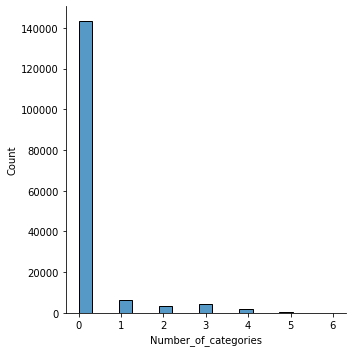

In [22]:
sns.displot(new_df.Number_of_categories)

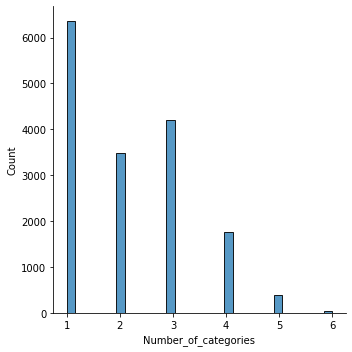

In [23]:
sns.displot(new_df.Number_of_categories[new_df['Number_of_categories'] > 0])

In [24]:
new_df[new_df.Number_of_categories == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      7,      8,
                 9,     10,
            ...
            159561, 159562, 159563, 159564, 159565, 159566, 159567, 159568,
            159569, 159570],
           dtype='int64', length=143346)

There are roughly 17000 (16225 to be precise) comments that belong to one of the 6 categories. The remaining 143346 of 159571 comments do not have any toxicity. This distribution may make the ML method biased.

##Important decision here

Since there are 16225 comments that belong to one of the 6 categories, select a number (larger or smaller or equal to 16225 in `num_of_nothing_bad`) of comments that do not belong to any of the categories to be in the training data. This eliminates the strong bias

In [25]:
num_of_nothing_bad = 20000 #replace the number here
index_list_none = random.sample(set(new_df[new_df.Number_of_categories == 0].index),num_of_nothing_bad)

In [26]:
index_list_atleast_one = new_df[new_df.Number_of_categories > 0].index

In [27]:
# drop_list = []
# for i in new_df.index:
#   if i not in index_list_none and i not in index_list_atleast_one:
#     drop_list.append(i)

In [28]:
# np.save('/content/drive/MyDrive/Project-2021/Sikka_AI/Saved_files/drop_list',drop_list)

In [29]:
drop_list = np.load('/content/drive/MyDrive/Project-2021/Sikka_AI/Saved_files/drop_list.npy')

In [30]:
new_df.drop(labels=drop_list,inplace=True)

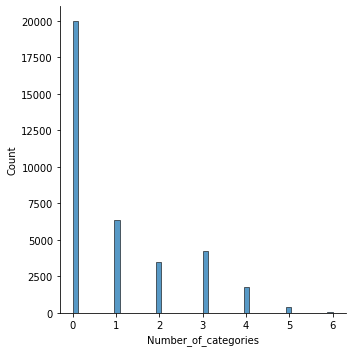

In [31]:
sns.displot(data=new_df['Number_of_categories'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


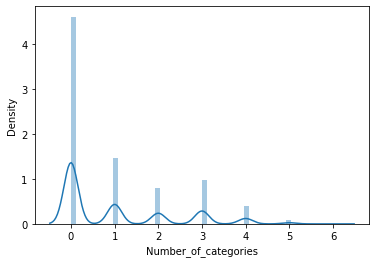

In [32]:
sns.distplot(new_df['Number_of_categories'])

In [33]:
new_df.reset_index(inplace=True)

In [34]:
new_df.drop(columns='index',inplace=True)

# Cleaning the data


In [35]:
new_df['comment_text']

0             COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
1        Hey... what is it..\n@ | talk .\nWhat is it......
2        Bye! \n\nDon't look, come or think of comming ...
3        The Mitsurugi point made no sense - why not ar...
4        "\nOk. But it will take a bit of work but I ca...
                               ...                        
36220    Retiring \n\nSince retiring from Wikipedia, I ...
36221    Your absurd edits \n\nYour absurd edits on gre...
36222    "\n\nHey listen don't you ever!!!! Delete my e...
36223    and i'm going to keep posting the stuff u dele...
36224    "\n Auto guides and the motoring press are not...
Name: comment_text, Length: 36225, dtype: object

In [36]:
def clean_text(text):
   
    # Convert text to all lowercase letters
    text = text.lower()
    
    # Remove whitespaces
    text = text.strip()
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove all tokens that are not alphabetic   r[A-Za-z#]
    tokens = [token for token in tokens if token.isalpha()]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords_list]
    
    # Remove tokens less than three letters
    tokens = [token for token in tokens if not len(token)<3]

    #Removing tokens more than 8 words
    tokens = [token for token in tokens if not len(token)>8]
    
    # Remove punctuations
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Lemmetize tokens
    tokens = [lemmatizer.lemmatize(token,pos='n') for token in tokens]
    
    # Stem tokens
    #tokens = 
    
    # Re-create text from filtered tokens, so that vectorizer won't complain
    text = ' '.join(tokens)
    return text

In [37]:
clean_df = new_df.copy()

In [38]:
clean_df['comment_text'] = clean_df['comment_text'].apply(lambda x: clean_text(x))

In [39]:
clean_df.comment_text

0                                         piss around work
1        hey talk group taliban good purist gang one as...
2                  bye look come think comming back tosser
3        point made sense argue include hindi ryo sakaz...
4            take bit work quite picture example base duck
                               ...                        
36220    retiring since retiring looking life become ob...
36221    absurd edits absurd edits great white shark to...
36222    hey listen ever delete edits ever annoyed wwe ...
36223    going keep posting stuff deleted fucking site ...
36224    auto guide motoring press good source article ...
Name: comment_text, Length: 36225, dtype: object

In [40]:
max([len(x.split()) for x in new_df['comment_text']])

1411

In [41]:
max([len(x.split()) for x in clean_df['comment_text']])

1250

In [42]:
clean_df['word_count'] = clean_df.comment_text.apply(lambda x: (len(x.split())))

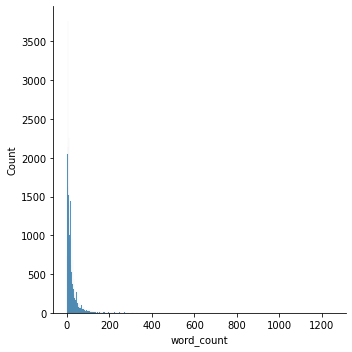

In [43]:
sns.displot(clean_df.word_count)

(0.0, 600.0)

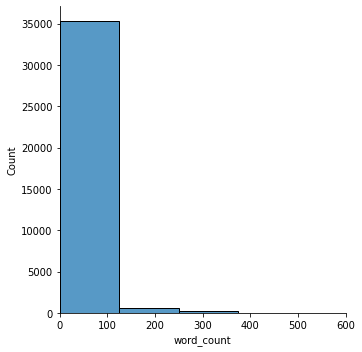

In [44]:
sns.displot(clean_df.word_count,bins=10)
plt.xlim((0,600))

In [45]:
clean_df.comment_text[clean_df.word_count > 600]

572      fuck useless bot fuck useless bot fuck useless...
1122     fuck bastard yyou life fuck bastard yank cock ...
1515     sex sex sex sex sex sex sex sexsex sex sex sex...
2032     ball ball ball ball ball ball ball ball ball b...
2602     thanks watching wiki raid thread ruining fun d...
3035     nigger nigger nigger nigger nigger nigger nigg...
4158     hey guy love chicken hey guy love chicken hey ...
5112     fuck nigga fuck nigga fuck nigga fuck nigga fu...
6225     damn cunt damn cunt damn cunt damn cunt damn c...
6630     jim wale must die jim wale must die jim wale m...
7389     pig pig pig pig pig pig pig pig pig pig pig pi...
7446     really wasnt bitch fat jew fat jew fat jew fat...
7938     suck suck suck suck suck suck suck suck suck s...
8768     bark bark bark bark bark bark bark bark bark b...
9118     jforget fuck faggot gay as chink nigger piece ...
9689     wanker wanker wanker wanker wanker wanker wank...
10630    heil hitler heil hitler heil hitler heil hitle.

It looks like the comments with more than 600 words are usually repititive.


In [46]:
clean_df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Number_of_categories,word_count
0,piss around work,1,1,1,0,1,0,4,3
1,hey talk group taliban good purist gang one as...,1,0,0,0,0,0,1,17
2,bye look come think comming back tosser,1,0,0,0,0,0,1,7
3,point made sense argue include hindi ryo sakaz...,0,0,0,0,0,0,0,10
4,take bit work quite picture example base duck,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...
36220,retiring since retiring looking life become ob...,0,0,0,0,0,0,0,36
36221,absurd edits absurd edits great white shark to...,1,0,1,0,1,0,3,24
36222,hey listen ever delete edits ever annoyed wwe ...,1,0,0,0,1,0,2,41
36223,going keep posting stuff deleted fucking site ...,1,0,1,0,1,0,3,20


In [47]:
clean_df['nothing_bad'] = 0

In [48]:
clean_df['nothing_bad'] = clean_df.apply(lambda x: 1 if x.Number_of_categories == 0 else 0, axis=1)

Lets truncate/pad each sequence/comments to 300 words. This decision is made from two points:
1.  Most of the sequences with words more than 600 have repititive words
2. An assumption that commentator expresses his context (toxic, obscene etc) in the first 300 sentences.

In [49]:
clean_df[clean_df.word_count<100][clean_df.Number_of_categories>1].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,toxic,severe_toxic,obscene,threat,insult,identity_hate,Number_of_categories,word_count,nothing_bad
count,9566.000000,9566.000000,9566.000000,9566.000000,9566.000000,9566.000000,9566.000000,9566.000000,9566.0
mean,0.976584,0.153878,0.823228,0.045996,0.768555,0.136630,2.904871,13.499477,0.0
std,0.151229,0.360851,0.381495,0.209488,0.421778,0.343474,0.837904,14.444390,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,4.000000,0.0
50%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,8.000000,0.0
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,17.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,98.000000,0.0


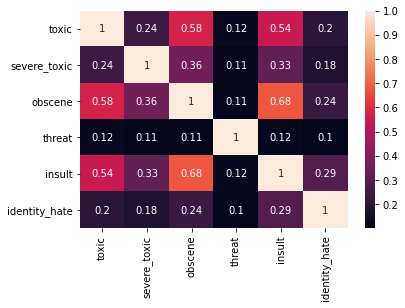

In [50]:

sns.heatmap(clean_df[clean_df.word_count<100].iloc[:,1:7].corr(), annot = True)

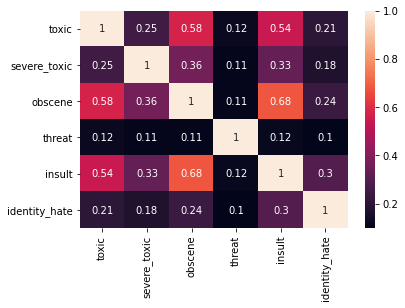

In [51]:

sns.heatmap(clean_df.iloc[:,1:7].corr(), annot = True)

Since the correlation between the texts does not have any significant change when we remove the comments that are longer than 100 words, lets use the comments shorter than 100 for now

In [52]:
clean_df = clean_df[clean_df.word_count<100]

#Saving files

In [53]:
x_train = clean_df['comment_text'].copy()

In [54]:
y_train = clean_df.iloc[:,[1,2,3,4,5,6,9]]

In [55]:
pd.to_pickle(clean_df,"/content/drive/MyDrive/Project-2021/Sikka_AI/Saved_files/records_20K.pkl")
pd.to_pickle(x_train,"/content/drive/MyDrive/Project-2021/Sikka_AI/Saved_files/train.pkl")
pd.to_pickle(y_train,"/content/drive/MyDrive/Project-2021/Sikka_AI/Saved_files/train_labels.pkl")